In [22]:
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.ticker as ticker
from osgeo import gdal
import salem
from salem import *

import fiona, rasterio
import geopandas as gpd
from rasterio.plot import show
import rasterio.plot as rplt
from rasterio.features import rasterize
from rasterstats import zonal_stats

## input files

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in less


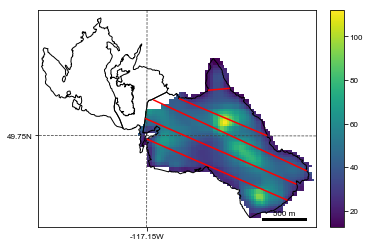

In [23]:
# season
balance = 'ba'  # bw or ba (winter or annual)
rho_snow = 470. # 470 kg m-3 geodetic or 457 glaciological, or...take given years obs. value
year = 2016 # any of: 2016, 2017, 2018
I = np.abs(year - 2016) # for selecting raster inputs

gl = 0 # number to select glacier
Glacier = ['Kokanee', 'Conrad']
glacier = ['kokanee', 'conrad']
d = 10. #20.  #distance between flux gate points

fl_path = '/home/pelto/Desktop/ice_flux/' + Glacier[gl] + '/'
gpr_path = '/home/pelto/GIS/GPR/ComparisonData/kokanee/'
path = '/home/pelto/Desktop/lidar_cbt_analysis/kokanee/'
vf_list = ['img1_20150419__img2_20160417_vmap_5m_35px_spm2/', 'img1_20160417__img2_20170521_vmap_5m_35px_spm2/',
      'img1_20160417__img2_20170521_vmap_5m_35px_spm2/' ]#
vf = vf_list[I]
vdir = '/home/pelto/Desktop/velocity_mapping/kokanee/' + vf 

topo = '/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20150912_kokanee_ppp_dem1_clip.tif'

dhW_list = ['kokanee_2017_winter_dh_dt.tif', 'kokanee_2017_winter_dh_dt.tif', 'kokanee_2018_winter_dh_dt2.tif']
dhA_list = ['kokanee_2016_2015_dh_dt.tif', 'kokanee_2017_2016_dh_dt_filled.tif','kokanee_2018_2017_dh_dt_21.tif']
if balance == 'bw':
    dh_r = path+ dhW_list[I]   #winter height change TIFF
else:
    dh_r = path+  dhA_list[I] #Annual height change TIFF

pts_file = fl_path + 'kokanee_gates_pts_10m_wgs84.shp'  ##must be WGS84 currently
gates = fl_path+'Kok_flux_gates.shp'
shpf = path + 'Kokanee/kok_all_glaciers_2015_dem.shp'   #GLIMS_BC/glims_all/all_glaciers_2016.shp' 
bins=fl_path+'kokanee_flux_bins.shp'

obs = pd.read_csv(fl_path+ 'kokanee_bdot.csv')
rho = pd.read_csv(fl_path + 'kokanee_rho.csv')  ## rho
rho_year = ['rho_2016','rho_2017','rho_2017']

# open GeoTIFF as array
VX = vdir+ vf[:-1] + '-F_vx.tif' 
VY = vdir+ vf[:-1] + '-F_vy.tif' 
vx = salem.open_xr_dataset(VX)  #gdal.Open(vx).ReadAsArray()
vy = salem.open_xr_dataset(VY)#gdal.Open(vy).ReadAsArray()
msk = salem.open_xr_dataset(fl_path + 'Kokanee_all_glaciers_2015_ice_msk_5m.tif') 
msk = msk.to_array(name='msk')
gpr = salem.open_xr_dataset(fl_path + 'gpr_outline_50_100m_5m.tif') #'gpr_outlines_all_25_25m_re5m.tif'
H_opt = salem.open_xr_dataset(fl_path+'opt_thick_101sw_MAE_utm_5m.tif') #'/home/pelto/oggm_runs/products_opt/Kokanee/Kokanee101sw_MAE_optimized.nc') 
#     pts = salem.read_shapefile(fl_path+pts)
gates = salem.read_shapefile(gates)

vx = vx.to_array(name='vx')
# np.shape(vx[0]) remove index 1 i.e.: 1,2000,3000
vy = vy.to_array(name='vy')
gpr = gpr.to_array(name='gpr')

H_opt_reproj = vx.salem.transform(H_opt)
H_opt = H_opt_reproj.to_array(name='H_opt')


gpr.data[gpr.data<0] = np.nan
gpr.data[gpr.data==1.000] == 0.0   #not having any effect
vx.data[msk.data==0] = np.nan
vy.data[msk.data==0] = np.nan


dem = salem.open_xr_dataset(topo)
dem_reproj = vx.salem.transform(dem)
dem = dem_reproj.to_array(name='dem')
dem.data[dem.data<1] = np.nan

# H_opt_reproj=vx.salem.transform(H_opt)
# H_opt = H_opt_reproj.to_array(name='H_opt')

#     # map extent
# grid = mercator_grid(center_ll=(-117.43, 51.238), extent=(4500, 4500)) ##zoomed out view
# 487892.000 5509738.000 491232.000 5512358.000
grid = vx.salem.grid  ##full view
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
sm.set_scale_bar()
sm.set_data(H_opt) #, label='m')

#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')


gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, linewidth=1)
sm.set_shapefile(gates, linewidth=1.5, color='r')
sm.visualize()
plt.savefig(fl_path+ 'products/'+ glacier[gl] +'_thickness_gates.png', dpi=300)
plt.show()

## Functions for calculating zonal statistics over each flux gate bin

In [24]:
# https://community.esri.com/groups/python-snippets/blog/2019/05/07/calculating-zonal-statistics-with-python-rasterstats
# For loading shapefiles into geopandas dataframe

def enum_items(source):
    print("\n")
    for ele in enumerate(source): 
        print(ele)
 
def list_columns(df):
    field_list = list(df)
    enum_items(field_list)
    return field_list

def loadshp_as_gpd(shp):
    data_shp = gpd.read_file(shp)
    return data_shp

# For loading feature classes into geopandas dataframe
def loadfc_as_gpd(fgdb):
    layers = fiona.listlayers(fgdb)
    enum_items(layers)
    index = int(input("Which index to load? "))
    fcgpd = gpd.read_file(fgdb,layer=layers[index])
    return fcgpd

# For re-projecting input vector layer to raster projection
def reproject(fcgpd, raster):
    proj = raster.crs.to_proj4()
    print("Original vector layer projection: ", fcgpd.crs)
    reproj = fcgpd.to_crs(proj)
    print("New vector layer projection (PROJ4): ", reproj.crs)
    fig, ax = plt.subplots(figsize=(15, 15))
    rplt.show(raster, ax=ax)
    reproj.plot(ax=ax, facecolor='none', edgecolor='red')
    fig.show()
    return reproj

def dissolve_gpd(df):
    field_list = list_columns(df)
    index = 1 #int(input("Dissolve by which field (index)? "))
    dgpd = df.dissolve(by=field_list[index])
    return dgpd

# For selecting which raster statistics to calculate
def stats_select():
    stats_list = stats_list = ['min', 'max', 'mean', 'count', 
              'sum', 'std', 'median', 'majority', 
              'minority', 'unique', 'range']
    enum_items(stats_list)
#     indices = input("Enter raster statistics selections separated by space: ")
    indices='2 3 5 6'
    stats  = list(indices.split())
    out_stats = list()
    for i in stats:
        out_stats.append(stats_list[int(i)])
    return out_stats

def get_zonal_stats(vector, raster, stats):
    # Run zonal statistics, store result in geopandas dataframe
    result = zonal_stats(vector, raster, stats=stats, geojson_out=True)
    geostats = gpd.GeoDataFrame.from_features(result)
    return geostats

## make an ice velocity quiver plot

In [25]:
# indices = input("Enter raster statistics selections separated by space: ")
# indices

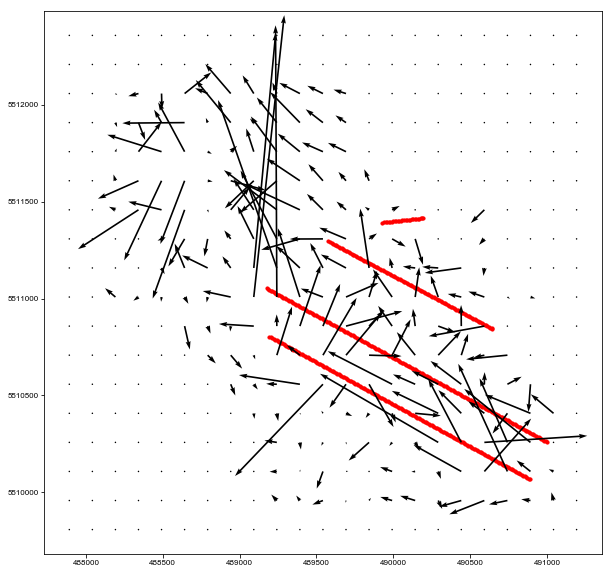

In [26]:
def quiver_plot():
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    df = salem.read_shapefile(pts_file) 
    df_file = loadshp_as_gpd(pts_file)
    df_file.crs

    coords = np.array([p.xy for p in df.geometry]).squeeze()
    df['lon'] = coords[:, 0]
    df['lat'] = coords[:, 1]

    
    xx, yy = salem.transform_proj(salem.wgs84, grid.proj, df['lon'].values, df['lat'].values)
    df['x'] = xx
    df['y'] = yy
    ax.scatter(df.x, df.y, s=10, c='r' )#c='depth',cmap='viridis', s=10, ax=ax);
    # shp_plt = reproject(df, VX)

    X, Y = np.meshgrid(vx.coords['x'],vx.coords['y'])
    U = vx.data[0]
    V = vy.data[0]

    # Q = ax.quiver(X, Y, U, V)#units='width', angles='uv') 
    Q = ax.quiver(X[::30, ::30], Y[::30, ::30], U[::30, ::30], V[::30, ::30], units='xy')
    # ax.set_xlim(502500, 507500)
    # ax.set_ylim( 5624000, 5631500)
    #     plt.quiver(vx.x, vx.y, vx.data ,vy.data)
    plt.savefig(fl_path+ 'products/'+ glacier[gl]+ str(year)+'_quiver.pdf', dpi=300)
    return df
# grid.ij_coordinates
# v_crs = check_crs(vx)

df = quiver_plot()

In [27]:
##select data desired for interpolation and/or aggregation
vns = ['vx',
       'vy',
       'gpr',
       'H_opt',
       'dem'
       #'msk',
       ]

M = xr.merge([vx,vy,gpr,H_opt,dem]) #dem

for vn in vns:
    df[vn] = M[vn][0].interp(x=('z', df.x), y=('z', df.y))  ##interp for interpolation, isel for aggregation

df

df_agg = df[['id', 'len', 'distance', 'angle', 'geometry', 'lon', 'lat']].copy()
ii, jj = grid.transform(df['lon'], df['lat'], crs=salem.wgs84, nearest=True)
df_agg['i'] = ii
df_agg['j'] = jj
# # We trick by creating an index of similar i's and j's
# df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in (vx.coords['x'], vx.coords['y'])]
df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
df_agg = df_agg.groupby('ij').mean()

# Select
for vn in vns:
#     M_maksed = np.ma.masked_invalid(M[vn][0])
#     df_agg[vn] = .interp(x=('z', df_agg.i), y=('z', df_agg.j))
    df_agg[vn] = M[vn][0].isel(x=('z', df_agg.i), y=('z', df_agg.j))
    
D = df_agg[['id', 'len', 'distance', 'angle', 'lon', 'lat', 'vx', 'vy', 'gpr', 'H_opt']].copy()
D

import math
D['vz'] = np.sqrt(D.vx**2 + D.vy**2 )  # np.sqrt(U**2 + V**2 )

D['vzdir'] = np.arcsin(D.vx/D.vz) *180/math.pi #degrees from north
D.vzdir[D.vzdir>0.0]=np.nan ## remove false velocity vectors which plague the accumulation zone


#multiply velocity vector by cosine of angle between vector and flux gate (line or line segment)
D['vfg'] = np.abs(D.vz * np.cos((D.vzdir-(D.angle-90.))*(math.pi/180.))) #velocity normal to gate per slice

# D[D.id==0].Qopt = D.vfg * 1.0 * 20. * D.H_opt
# D[D.id==1].Qopt = D.vfg * 1.0 * 20. * D.H_opt
D['Qopt'] = D.vfg * 0.9 * d * D.H_opt     ## ice flux per slice *0.9 to est. depth-integrated velocity
D['a'] = 20. * D.H_opt #area per slice

##calculate flux for lowest two bins assuming surface vel. = depth integrated vel.
# KP=[]
# for loop in D.index:
#     ID= D[D.index==loop].id.values
#     if ((ID==0) | (ID==1)):
#         KP.append( (D[D.index==loop].vfg * 1.0 * 20. * D.H_opt[D.index==loop]).values[0])
#     else:
#         KP.append((D[D.index==loop].vfg * 0.9 * 20. * D.H_opt[D.index==loop]).values[0]  )  ## ice flux per slice *0.9 to est. depth-integrated velocity
# D['Qopt'] = KP


D

Q_out= [0.,] #flux out per gate
cr_area = [0.,] # cross-section area per gate
vzdir = [0.,]

for n in range(D.id.nunique()+1):
        Q_out.append(D.Qopt[D.id==n].sum()) 
        cr_area.append(D.a[D.id==n].sum())
        vzdir.append(D.vzdir[D.id==n].mean())           
Q_in = [Q_out[1:]] #flux in per bin
Q_in = np.squeeze(Q_in)
# Q_in[]


##create dataframe with data per flux bin  
FG = pd.DataFrame(list(zip(Q_out, Q_in, cr_area, vzdir)), columns=['Q_out', 'Q_in', 'cr_area', 'vzdir']) 
FG['vfg'] = FG.Q_out / FG.cr_area #net velocity per gate
FG['bin']=np.arange(0,len(range(D.id.nunique()+1)),1)

FG

/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Q_out,Q_in,cr_area,vzdir,vfg,bin
0,0.000000,2280.836246,0.000000,0.000000,NaN,0
1,2280.836246,75788.938098,16121.385384,-84.646378,0.141479,1
2,75788.938098,206139.691521,127027.549934,-42.630074,0.596634,2
3,206139.691521,114370.014241,195976.226921,-39.059673,1.051861,3
4,114370.014241,0.000000,160701.876755,-45.422028,0.711691,4


Original vector layer projection:  {'init': 'epsg:2955'}
New vector layer projection (PROJ4):  +init=epsg:2955


/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())




(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')
Original vector layer projection:  {'init': 'epsg:2955'}
New vector layer projection (PROJ4):  +init=epsg:2955


/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())




(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')
Original vector layer projection:  {'init': 'epsg:2955'}
New vector layer projection (PROJ4):  +init=epsg:32611


(0, 'min')
(1, 'max')
(2, 'mean')
(3, 'count')
(4, 'sum')
(5, 'std')
(6, 'median')
(7, 'majority')
(8, 'minority')
(9, 'unique')
(10, 'range')


/home/pelto/anaconda2/envs/flux/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


,Q_out,Q_in,cr_area,vzdir,vfg,bin,dh_count,dh_mean,dh_med,dh_std,dem_count,dem_mean,dem_med,dem_std,vm_count,vm_mean,vm_med,vm_std
0,0.000000,2280.836246,0.000000,0.000000,NaN,0,63555,-1.777570,-1.762939,0.775152,63555,2291.147384,2295.720703,29.613614,829,2.534091,2.373828,1.389615
1,2280.836246,75788.938098,16121.385384,-84.646378,0.141479,1,226674,-0.441372,-0.364502,0.658413,226674,2424.755905,2431.459473,37.438778,8511,2.440918,2.119874,1.436684
2,75788.938098,206139.691521,127027.549934,-42.630074,0.596634,2,741064,0.262267,0.212158,0.482645,741064,2559.920028,2559.432129,52.660590,28867,4.686297,3.663807,4.050530
3,206139.691521,114370.014241,195976.226921,-39.059673,1.051861,3,419741,0.597195,0.571045,0.549125,419741,2656.073264,2659.287109,30.869152,16794,6.113478,4.542166,5.688607
4,114370.014241,0.000000,160701.876755,-45.422028,0.711691,4,336893,0.686625,0.690430,0.671824,336893,2717.695553,2715.403076,27.732569,13274,4.968661,3.674392,4.316637


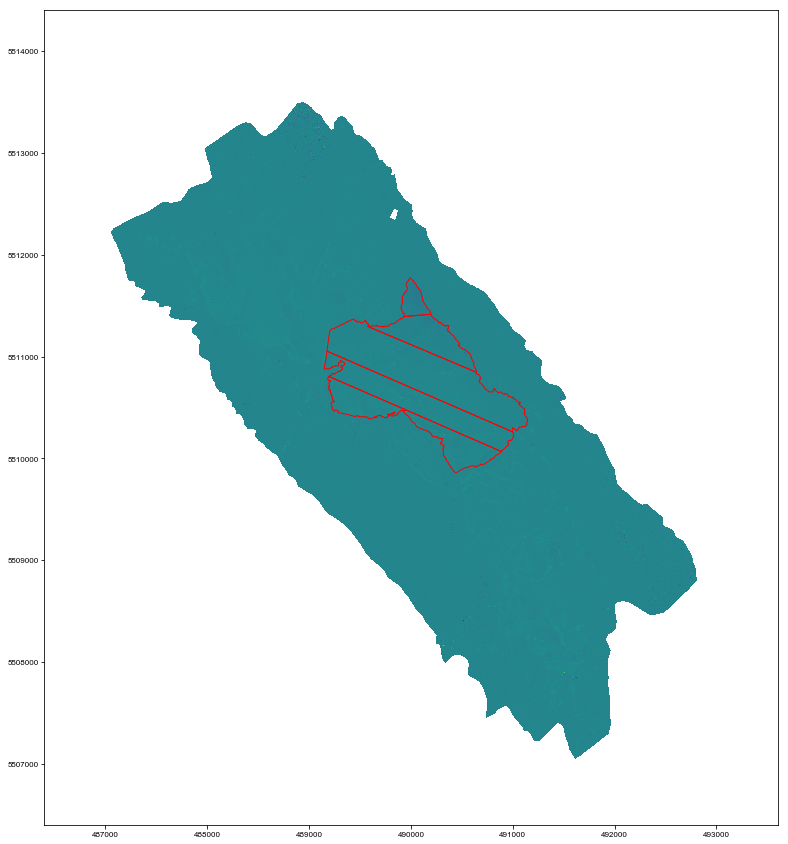

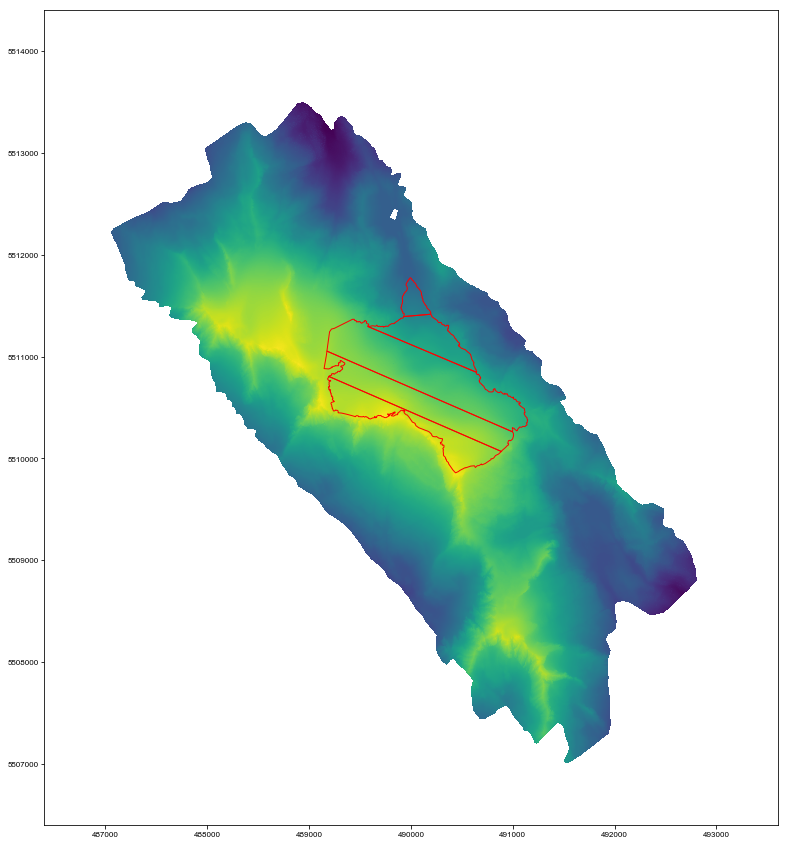

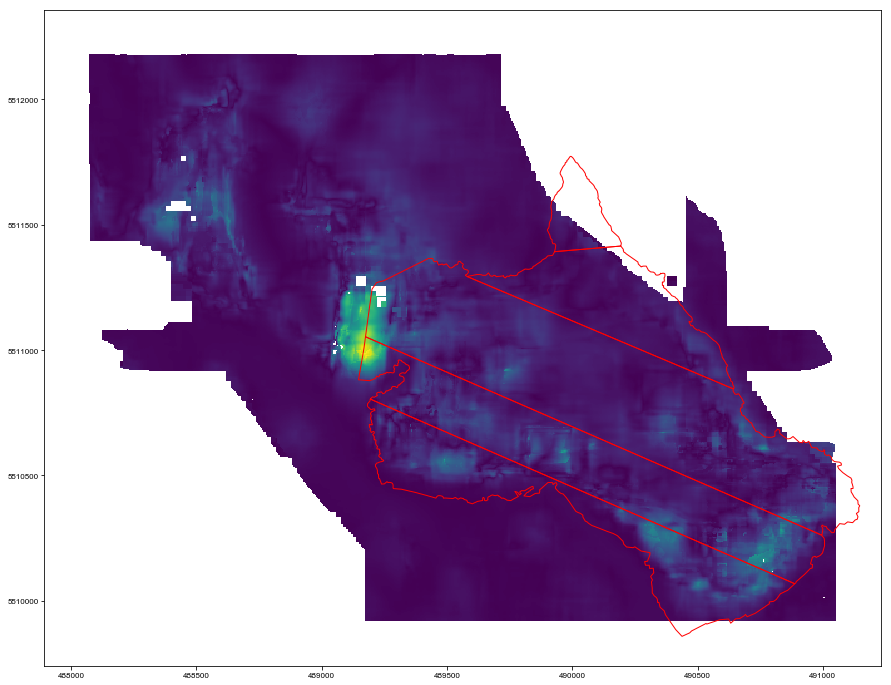

In [28]:
### import data per bin: height change, elevation, surface area, obs.SMB etc. 

dem_r = topo
vel_r = vdir + vf[:-1] + '-F_vm.tif'
shp = loadshp_as_gpd(bins)

def zonal_statistics_bins():
    ### calculate zonal statistics per bin
    rasters = [dh_r, dem_r, vel_r]
    names = ['dh','dem','vm']
    FG_df = FG.copy()
    for i in range(len(rasters)):
        raster = rasters[i]
        rst = rasterio.open(raster)
        shape = reproject(shp, rst) #shp is in correct projection, trying anyway for calculation
        # dhdt= vx.salem.transform(dhdt)
        name = names[i]
    #     shp_vec = dissolve_gpd(shp)  ## only if more columns exist
        stats = stats_select()  #'['min', 'max', 'mean', 'count', 'sum', 'std', 'median', 'majority', 'minority', 'unique', 'range']
        ZS = (get_zonal_stats(shape, raster, stats))
        ZS.drop(['geometry'], axis=1, inplace=True)
        ZS.rename(columns={"mean": name+"_mean", "median":name+"_med", "std": name+"_std", "count":name+"_count"}, inplace=True)
        ZS.sort_values(by=['bin'],ascending=True, inplace=True)
        ZS.set_index('bin', inplace=True)
        
        FG_df =  pd.concat([FG_df, ZS], axis=1)
    return FG_df

FG_df= zonal_statistics_bins()
FG_df

In [29]:
rho.bin

0    0
1    1
2    2
3    3
4    4
Name: bin, dtype: int64

In [30]:
rho.drop('bin', axis=1, inplace=True)
rho

,rho_2016,rho_2017,rho_2018,mean
0,910,910,910,910.000000
1,910,910,910,910.000000
2,850,750,950,850.000000
3,600,600,625,608.333333
4,600,600,600,600.000000


In [31]:
# rho.sort_values(by=['bin'],ascending=True, inplace=True) # sort by bin
# rho_yr = rho_year[I]
# rho.set_index('bin', inplace=True) # set bin as index for sorting
# rho[0:4]
FG_df =  pd.concat([FG_df, rho], axis=1)
FG_df

FG_df['Q_net'] = FG_df.Q_in - FG_df.Q_out  #net flux per gate
FG_df['Q_netA']= FG_df.Q_net / FG_df.dem_count
FG_df['b_fg_h'] = FG_df.dh_mean - FG_df.Q_netA
if balance == 'bw':
    FG_df['b_fg_we'] = rho_snow/1000. * FG_df.b_fg_h
else:
    FG_df['b_fg_we'] = FG_df.rho_2018/1000. * FG_df.b_fg_h
# FG_df.drop(FG_df.tail(1).index,inplace=True)
FG_df

,Q_out,Q_in,cr_area,vzdir,vfg,bin,dh_count,dh_mean,dh_med,dh_std,...,vm_med,vm_std,rho_2016,rho_2017,rho_2018,mean,Q_net,Q_netA,b_fg_h,b_fg_we
0,0.000000,2280.836246,0.000000,0.000000,NaN,0,63555,-1.777570,-1.762939,0.775152,...,2.373828,1.389615,910,910,910,910.000000,2280.836246,0.035888,-1.813458,-1.650247
1,2280.836246,75788.938098,16121.385384,-84.646378,0.141479,1,226674,-0.441372,-0.364502,0.658413,...,2.119874,1.436684,910,910,910,910.000000,73508.101852,0.324290,-0.765662,-0.696752
2,75788.938098,206139.691521,127027.549934,-42.630074,0.596634,2,741064,0.262267,0.212158,0.482645,...,3.663807,4.050530,850,750,950,850.000000,130350.753423,0.175897,0.086370,0.082052
3,206139.691521,114370.014241,195976.226921,-39.059673,1.051861,3,419741,0.597195,0.571045,0.549125,...,4.542166,5.688607,600,600,625,608.333333,-91769.677280,-0.218634,0.815829,0.509893
4,114370.014241,0.000000,160701.876755,-45.422028,0.711691,4,336893,0.686625,0.690430,0.671824,...,3.674392,4.316637,600,600,600,600.000000,-114370.014241,-0.339485,1.026109,0.615666


In [32]:
FG_df.rho_2018

0    910
1    910
2    950
3    625
4    600
Name: rho_2018, dtype: int64

In [33]:
D['Agpr']=np.NaN
D.sort_values(by=['distance'],ascending=True, inplace=True) 
for n in range(D.id.nunique()):

    for c in range(D.id[D.id==n].count()-1):
        idx=D[(D.id==n)&(D.distance==D[D.id==n].distance[c])].index
        
        if c==0:
            G= D.distance[D.id==n][c+1] - D.distance[D.id==n][c] * D.gpr[D.id==n][c+1]*0.5 #area of triangle
        elif c==1:
            G= (D.distance[D.id==n][c+1] - D.distance[D.id==n][c])/2 * D.gpr[D.id==n][c]
        elif c==len(D.id[D.id==n])-2: #
            G= (D.distance[D.id==n][c] - D.distance[D.id==n][c-1])/2 * D.gpr[D.id==n]
        elif c==len(D.id[D.id==n])-1:  #last point in line
            G= D.distance[D.id==n][c] + D.distance[D.id==n][c+1] * D.gpr[D.id==n][c-1]*0.5 #area of triangle
        else:
            G=(((D.distance[D.id==n][c+1]-D.distance[D.id==n][c])/2) + ((D.distance[D.id==n][c] -
                    D.distance[D.id==n][c-1])/2))* D.gpr[D.id==n][c]  
       
        D.loc[idx,'Agpr']= G
#         D['Q_gpr'] = (D.vfg * 0.9 *D['Agpr'])
#     D['A'] = D.vfg[D.id==n] * D.gpr[D.id==n]

#calculate flux out using GPR thicknesses
D['Qo_gpr'] = D.Agpr * D.vfg * 0.9

# D.to_csv(fl_path+'kokanee_gpr_fluxG_pts.csv')

# for i in range(len(range(D.id.nunique()+1))):
#     print(i, D.Agpr[D.id==i].mean())

Qo_gpr = [0.,] #flux out per gate
cr_area_gpr = [0.,] # cross-section area per gate
vzdir_gpr = [0.,]
n=0
for n in range(D.id.nunique()):
        Qo_gpr.append(D.Qo_gpr[D.id==n].sum()) 
        cr_area_gpr.append(D.Agpr[D.id==n].sum())
        vzdir_gpr.append(D.vzdir[D.id==n].mean())           
Qin_gpr = [Qo_gpr[1:]+ [0.0]] #flux in per bin, add zero to end for top bin (for now)
Qin_gpr = np.squeeze(Qin_gpr)

FG_gpr = pd.DataFrame(list(zip(Qo_gpr, Qin_gpr, cr_area_gpr)), columns=['Qo_gpr', 'Qin_gpr', 'cr_area_gpr']) 
FG_gpr['bin'] = np.arange(0,len(range(D.id.nunique()+1)),1)#[0,1,2,3]
# FG_gpr['vfg'] = FG_gpr.Qo_gpr / FG_gpr.cr_area_gpr #net velocity per gate
# FG['bin']=np.arange(0,14,1)
FG_gpr

### calculate flux and SMB
FG_all = FG_df.merge(FG_gpr, how='left') #on='bin')  #how='left') #
FG_all
FG_all['Q_net_gpr'] = FG_all.Qin_gpr - FG_all.Qo_gpr 
FG_all['Q_netA_gpr']= FG_all.Q_net_gpr / FG_all.dem_count
FG_all['b_fg_h_gpr'] = FG_all.dh_mean - FG_all.Q_netA_gpr  #dh1516_mean
if balance == 'bw':
    FG_all['b_fg_we_gpr'] = rho_snow/1000. * FG_all.b_fg_h_gpr
else:
    FG_all['b_fg_we_gpr'] = FG_all['rho_%s'%year]/1000. * FG_all.b_fg_h_gpr
# FG_all.drop(FG_all.tail(1).index,inplace=True)
FG_all['dem_mean']

0    2291.147384
1    2424.755905
2    2559.920028
3    2656.073264
4    2717.695553
Name: dem_mean, dtype: float64

## Plot balance gradients

0.004850891000010994 -12.454661600724416 0.6372540832524696 0.0010739124304989997 0.00128014318684662
0.0050227396970780516 -12.929270737372523 0.9662369006852236 0.0074094428191465245 0.0007732777233813016
0.005407567624628032 -13.908582678641276 0.9885831829144827 0.001461861687372437 0.00047585267639504666


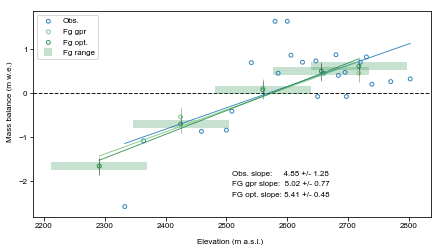

In [34]:
from scipy import stats
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import statsmodels.api as stm

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle


font = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 8}

plt.rc('font', **font)

fig, ax = plt.subplots(1, sharex=True, sharey=True, figsize=(6,3.34))#3.34, 3.34))
# j,k=0,0    ## only define j if one row
n = 0
s= 15 #markersize

a = 0.9
color=['b', 'lime', 'green']

##all_obs
if balance == 'bw':
    obs = obs.dropna(subset=['Bw'])
    y_ax_obs=obs[(obs.Year==year)].Bw

else:
    obs = obs.dropna(subset=['Ba'])
    y_ax_obs=obs[(obs.Year==year)].Ba


x_ax_obs=obs[(obs.Year==year)].Elev
##obs by bin
# x_ax_obs=FG_df._elevmean  #FG_df.elev_mean
# y_ax_obs=FG_df.b_obs16#b_obs

# Drop unrealistic FG smb:
new = FG_all.copy()

new = new[new.b_fg_we >-8.]
new = new[new.b_fg_we_gpr >-8.]

#errors (above and below)
new['yerr'] = 0.20
yerr = new.yerr
new['xerr'] = new.dem_std * 1.5 #2 std dev -- 95% of data
xerr = new.xerr 

 
x_ax_fg_gpr=new.dem_mean
y_ax_fg_gpr=new.b_fg_we_gpr

x_ax_fg_opt=new.dem_mean  #FG_df.elev_mean
y_ax_fg_opt=new.b_fg_we

###############################################

def make_error_boxes(ax, xdata, ydata, xerror, yerror, facecolor='r',
                     edgecolor='None', ecolor='None', alpha=0.5):

    # Create list for all the error patches
    errorboxes = []
    
    # Loop over data points; create box from errors at each point
    for x, y, xe, ye in zip(xdata, ydata, xerror, yerror):
        rect = Rectangle((x - xe, y), xe, 0.05)
        errorboxes.append(rect)

#     # Create patch collection with specified colour/alpha
#     pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
#                          edgecolor=edgecolor)
#     # Add collection to axes
#     ax.add_collection(pc)

    # Plot errorbars
    artists = ax.errorbar(xdata, ydata, xerr=None, yerr=yerror, fmt='None', ecolor='k', zorder=2,
                          elinewidth=0.7, marker='d', label='', ls='..', alpha=0.4)


    return artists #, theives

###############################################


x = [x_ax_obs, x_ax_fg_gpr, x_ax_fg_opt]
y = [y_ax_obs, y_ax_fg_gpr, y_ax_fg_opt]
color = ['#1f78b4', '#74c476', '#238b45']
label = ['Obs.', 'Fg gpr', 'Fg opt.']

# Call function to create error bars 
for i in range(2):
    _ = make_error_boxes(ax, x[i+1], y[i+1], xerr, yerr, ecolor=color[i+1])
    
## create range bar to represent flux gate elevation range
theives = ax.errorbar(x[2], y[2], xerr=xerr[2], yerr=None, fmt='None', ecolor=color[2], zorder=1,
                          elinewidth=8, marker='d', label='Fg range', ls='..', alpha=0.25)

## plot data and regression lines

ytxt = [0.2, 0.15, 0.1]
for i in range(3):
#     fit = np.polyfit(x[i],y[i],2)
#     y_new = np.polyval(fit,x[i])
#     ax.plot(x[i],y[i],c=color[i], linewidth=1.0, linestyle='--', alpha=a-0.1)

    slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(x[i]),np.array(y[i]))
    ax.scatter(x[i],y[i],color=color[i], label=label[i], alpha=a, s=s,facecolor='', zorder=3)
    ax.plot(x[i],slope*x[i]+intercept, color=color[i],label='', alpha=a, linewidth=0.9, zorder=3)
    print(slope, intercept, r_value, p_value, std_err)
    txt= ['Obs. slope:     ', 'FG gpr slope:  ', 'FG opt. slope: ']
           
#     'H_{opt}''slope:$'
    ax.text(0.5, ytxt[i], txt[i]+str(np.round(1000*slope,2))+ ' +/- ' + str(np.round(1000*std_err,2)), 
            transform=ax.transAxes)
    
if balance == 'ba':
    ax.axhline(linewidth=1, color='k', ls='--', alpha=a, zorder=0)





fig.subplots_adjust(bottom=0.12, top=0.98, hspace=0.1, left=0.07, right=0.99, wspace=0.05)#left=0.07, right=0.9,wspace=0.05, 
ax.legend(loc='upper left')#, bbox_to_anchor=(0, 0.42, 0.7, 0.5), labelspacing=0.2, handletextpad=0.1)
fig.text(0.01, 0.75, 'Mass balance (m w.e.)', rotation=90)
fig.text(0.45, 0.01, 'Elevation (m a.s.l.)')

plt.savefig(fl_path + 'products/' + glacier[gl]+'_bdot_' + balance + str(year) +'.png', dpi=300) #+ Glacier[gl]

plt.show()

In [35]:
y= -0.0001780082523748254 + 2.605561634861116

In [36]:
new

,Q_out,Q_in,cr_area,vzdir,vfg,bin,dh_count,dh_mean,dh_med,dh_std,...,b_fg_we,Qo_gpr,Qin_gpr,cr_area_gpr,Q_net_gpr,Q_netA_gpr,b_fg_h_gpr,b_fg_we_gpr,yerr,xerr
0,0.000000,2280.836246,0.000000,0.000000,NaN,0,63555,-1.777570,-1.762939,0.775152,...,-1.650247,0.000000,2709.841317,0.000000,2709.841317,0.042638,-1.820208,-1.656389,0.2,44.420421
1,2280.836246,75788.938098,16121.385384,-84.646378,0.141479,1,226674,-0.441372,-0.364502,0.658413,...,-0.696752,2709.841317,34952.049449,9323.918030,32242.208133,0.142240,-0.583613,-0.531087,0.2,56.158166
2,75788.938098,206139.691521,127027.549934,-42.630074,0.596634,2,741064,0.262267,0.212158,0.482645,...,0.082052,34952.049449,118801.045337,24059.532051,83848.995887,0.113147,0.149120,0.126752,0.2,78.990885
3,206139.691521,114370.014241,195976.226921,-39.059673,1.051861,3,419741,0.597195,0.571045,0.549125,...,0.509893,118801.045337,28068.760173,63577.135992,-90732.285164,-0.216163,0.813358,0.488015,0.2,46.303727
4,114370.014241,0.000000,160701.876755,-45.422028,0.711691,4,336893,0.686625,0.690430,0.671824,...,0.615666,28068.760173,0.000000,24941.926537,-28068.760173,-0.083317,0.769941,0.461965,0.2,41.598854


In [37]:
new['FG_opt_m3_we'] = new.b_fg_we * new.dem_count
new['FG_gpr_m3_we'] = new.b_fg_we_gpr * new.dem_count

B_opt = (new.FG_opt_m3_we.sum()) / (new.dem_count.sum())
B_gpr = new.FG_gpr_m3_we.sum() / new.dem_count.sum()

In [38]:
gg = new['FG_opt_m3_we'].sum()
gg

219425.05382982283

In [39]:
gg = new['FG_gpr_m3_we'].sum()
gg

228748.41288634774

In [40]:
new

,Q_out,Q_in,cr_area,vzdir,vfg,bin,dh_count,dh_mean,dh_med,dh_std,...,Qin_gpr,cr_area_gpr,Q_net_gpr,Q_netA_gpr,b_fg_h_gpr,b_fg_we_gpr,yerr,xerr,FG_opt_m3_we,FG_gpr_m3_we
0,0.000000,2280.836246,0.000000,0.000000,NaN,0,63555,-1.777570,-1.762939,0.775152,...,2709.841317,0.000000,2709.841317,0.042638,-1.820208,-1.656389,0.2,44.420421,-104881.424656,-105271.819270
1,2280.836246,75788.938098,16121.385384,-84.646378,0.141479,1,226674,-0.441372,-0.364502,0.658413,...,34952.049449,9323.918030,32242.208133,0.142240,-0.583613,-0.531087,0.2,56.158166,-157935.675888,-120383.712604
2,75788.938098,206139.691521,127027.549934,-42.630074,0.596634,2,741064,0.262267,0.212158,0.482645,...,118801.045337,24059.532051,83848.995887,0.113147,0.149120,0.126752,0.2,78.990885,60805.607686,93931.511308
3,206139.691521,114370.014241,195976.226921,-39.059673,1.051861,3,419741,0.597195,0.571045,0.549125,...,28068.760173,63577.135992,-90732.285164,-0.216163,0.813358,0.488015,0.2,46.303727,214023.138144,204839.777348
4,114370.014241,0.000000,160701.876755,-45.422028,0.711691,4,336893,0.686625,0.690430,0.671824,...,0.000000,24941.926537,-28068.760173,-0.083317,0.769941,0.461965,0.2,41.598854,207413.408544,155632.656104


In [41]:
print(B_opt)
print(B_gpr)


0.12272595795567874
0.12794057748797782


## Plot flux gates as cross-sections

No handles with labels found to put in legend.


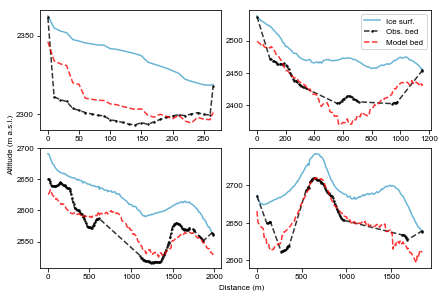

In [42]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='2'
pylab.rcParams['ytick.major.pad']='2'

j,k = 0,0
n=0
# df_agg['area_opt'] = df_agg.thick_opt * 10 
a=0.8
letter='a','b','c','d'

obs_H = df_agg.copy()
obs_H = obs_H.dropna(subset=['gpr']) #, inplace=True)   

fig, ax = plt.subplots(2,2)
for i in range(4):
    
    # plot glacier surface
    ax[j,k].plot(df_agg[df_agg.id==i].distance, (df_agg[df_agg.id==i].dem), color='#43a2ca', alpha=a, label='Ice surf.')
    
    #plot gpr thickness gates
    gpr=(obs_H[obs_H.id==i].dem)-(obs_H[obs_H.id==i].gpr)
    gpr_mask=np.isfinite(gpr)
    ax[j,k].plot(obs_H[obs_H.id==i].distance, gpr, marker='o'
                 , ms=1.5, ls='--', color='k', alpha=a, label='Obs. bed')
    
#         ax[j,k].set_ylim(((df_agg.elev[df_agg.id_opt==i])-(df_agg[df_agg.id_opt==i].thick_opt)+5).max(), -5)
    
    ##plot optimized thickness gates
    ax[j,k].plot(df_agg[df_agg.id==i].distance, (df_agg[df_agg.id==i].dem)-(df_agg[df_agg.id==i].H_opt), 
                 ls='--', c='r', alpha=a, label='Model bed')  #marker='o')
    
    ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(50)) ##
#     ax[j,k].text(0.05, 0.05, letter[i], transform=ax[j,k].transAxes, fontweight='bold', fontsize=10, verticalalignment='center', horizontalalignment='center',)
    n += 1

    k += 1
    if n == 2: 
        j += 1
        k = 0  
         
    ax[0,1].legend()
      
fig.text(0.01, 0.6, 'Altitude (m a.s.l.)', rotation=90)
fig.text(0.5, 0.01, 'Distance (m)')     
fig.subplots_adjust(bottom=0.085, top=0.98, left=0.085, right=0.99, wspace=0.15, hspace=0.15) 

plt.savefig(fl_path + 'products/' + glacier[gl]+'_flux_gates.png', dpi=300)
plt.show()

# for i in range(4):
#     area=df_agg[df_agg.id_opt==i].area_opt
#     area_total = area.sum()
#     print(area_total)        

## 